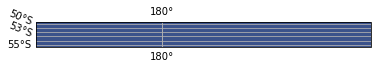

0.0


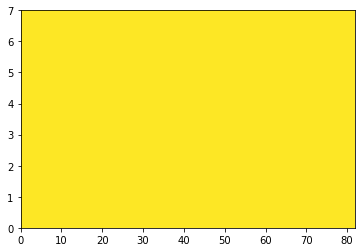

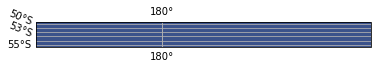

0.0


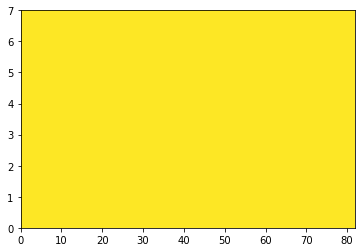

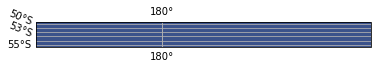

0.0


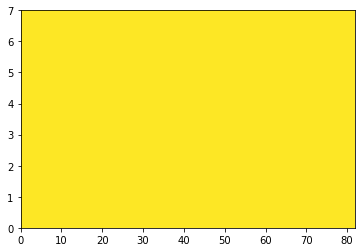

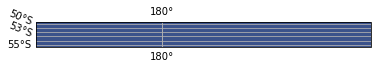

0.0


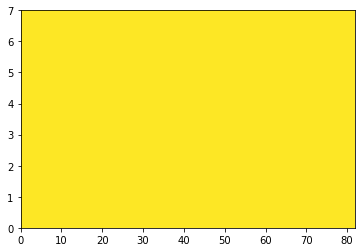

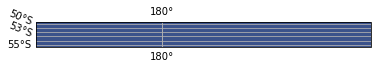

0.0


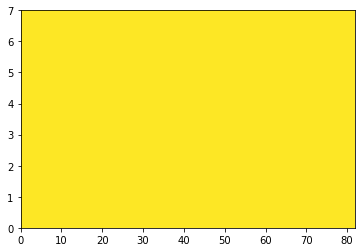

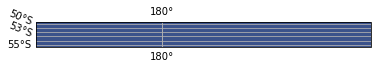

0.0


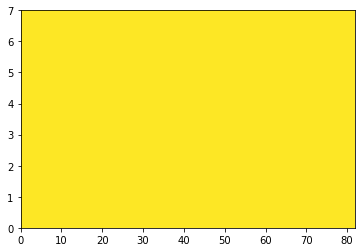

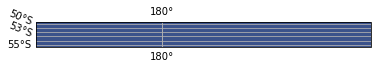

0.0


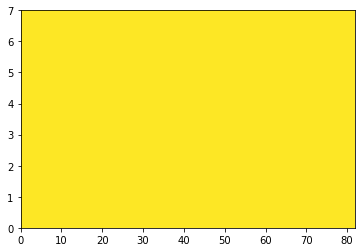

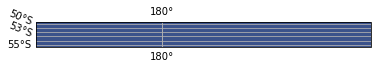

0.0


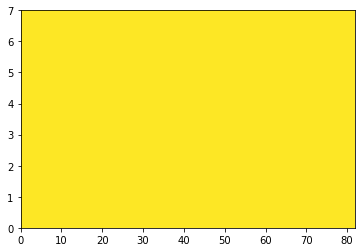

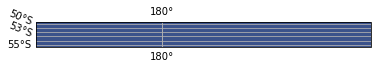

0.0


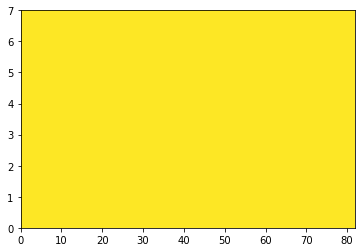

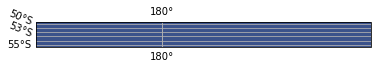

0.0


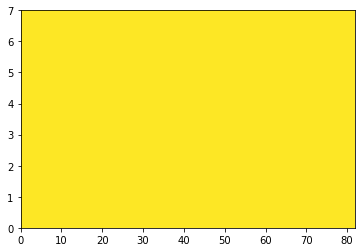

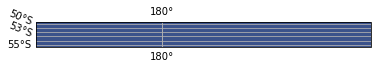

0.0


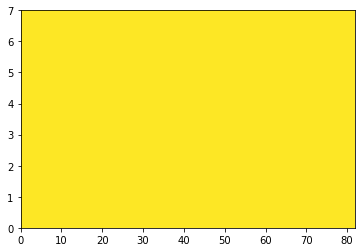

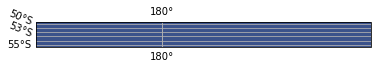

0.0


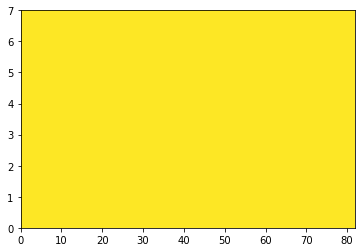

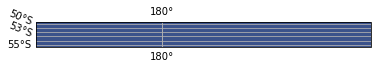

0.0


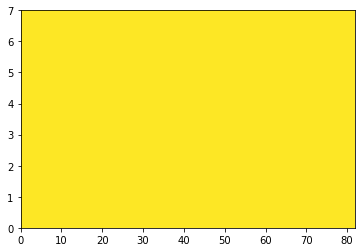

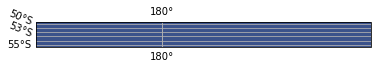

0.0


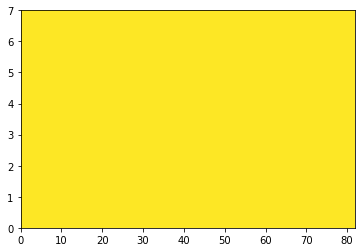

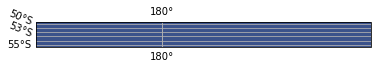

0.0


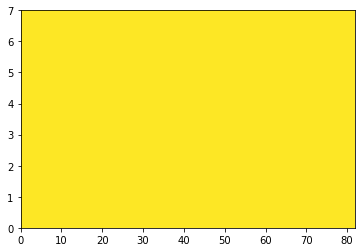

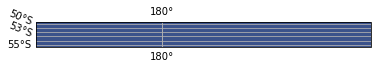

0.0


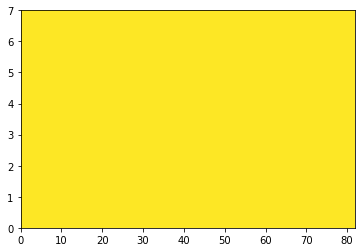

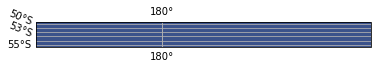

0.0


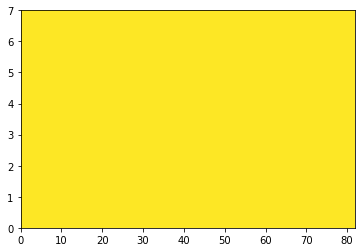

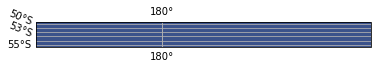

0.0


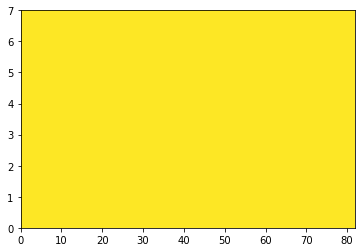

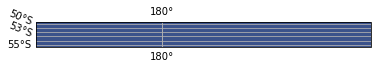

0.0


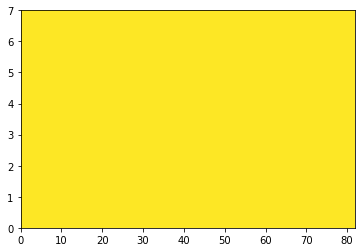

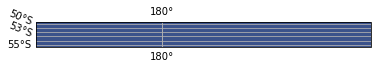

0.0


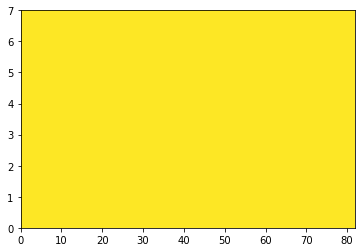

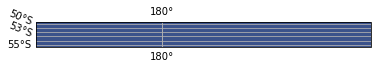

0.0


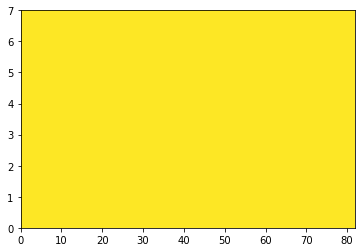

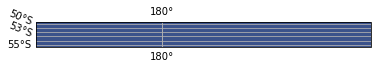

0.0


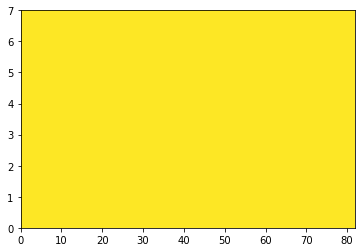

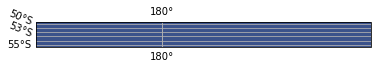

0.0


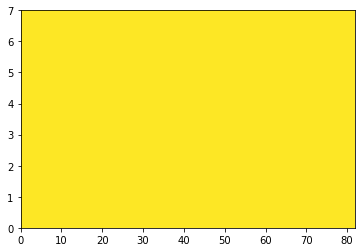

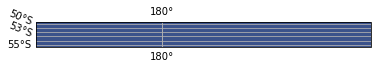

0.0


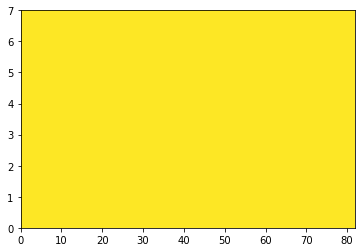

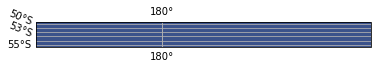

0.0


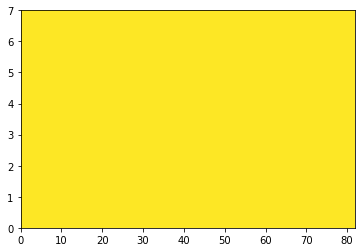

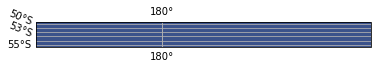

0.0


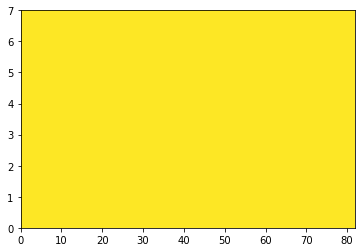

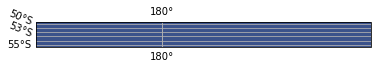

0.0


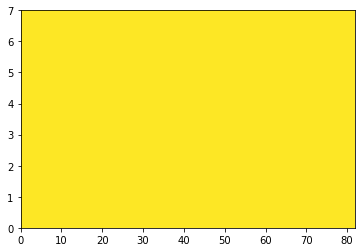

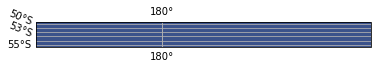

0.0


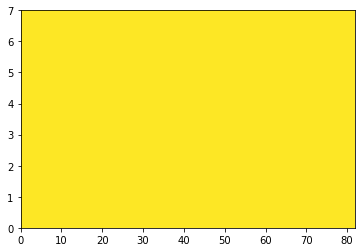

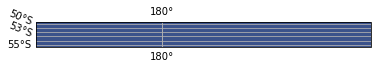

0.0


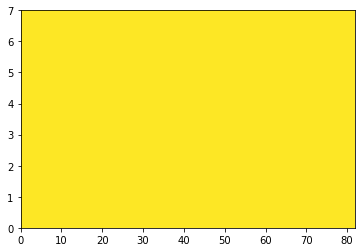

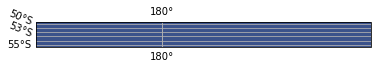

0.0


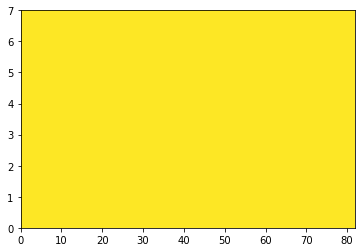

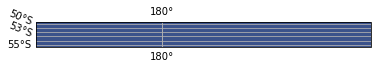

0.0


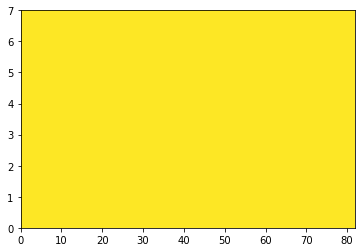

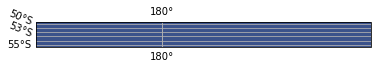

0.0


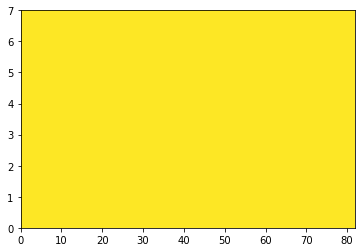

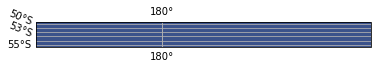

0.0


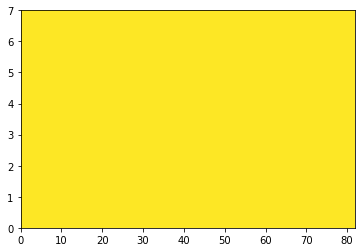

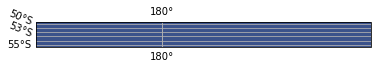

0.0


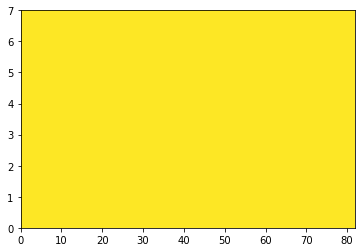

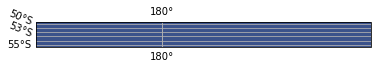

0.0


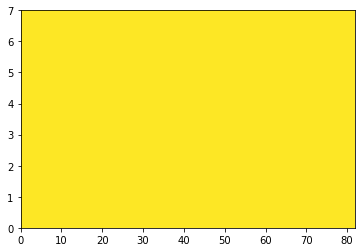

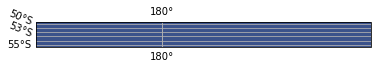

0.0


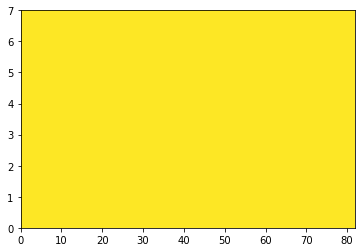

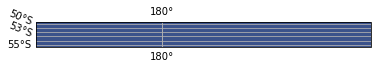

0.0


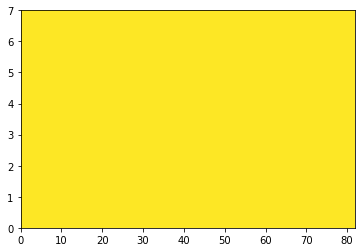

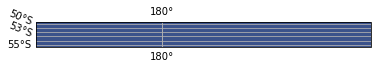

0.0


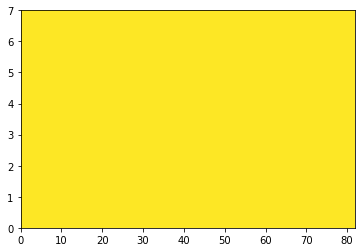

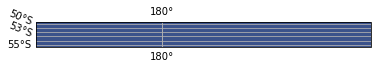

0.0


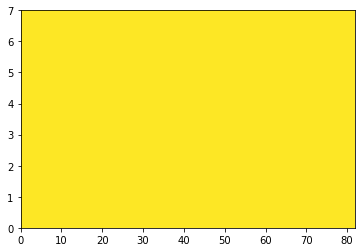

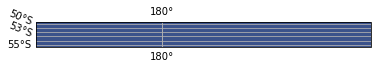

0.0


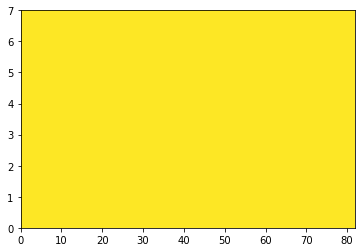

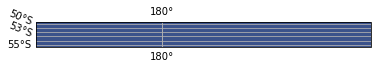

0.0


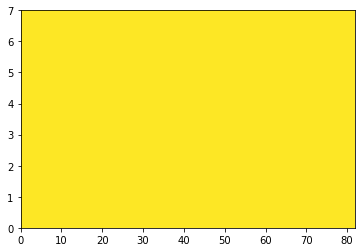

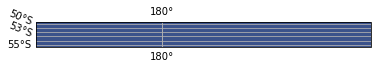

0.0


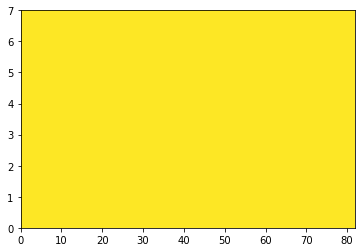

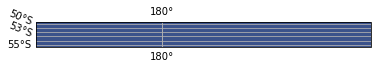

0.0


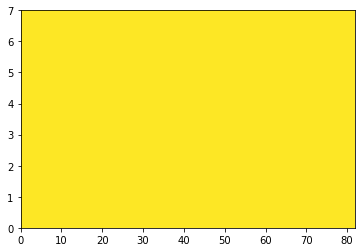

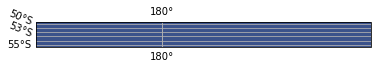

0.0


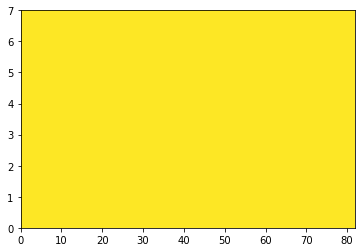

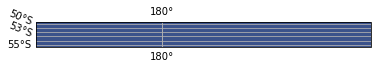

0.0


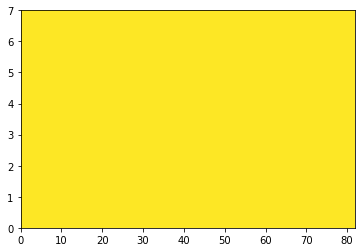

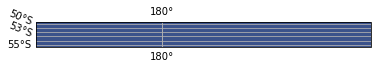

0.0


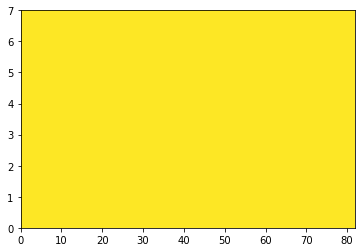

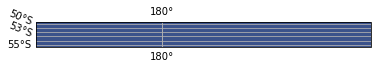

0.0


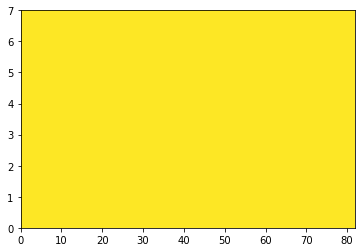

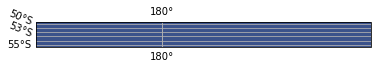

0.0


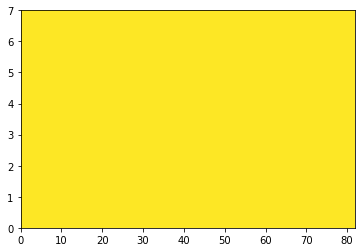

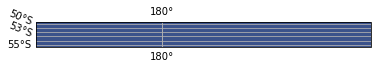

0.0


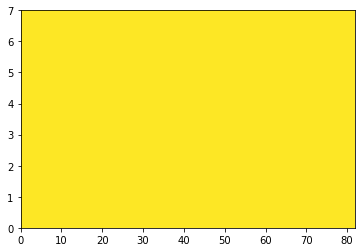

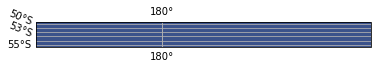

0.0


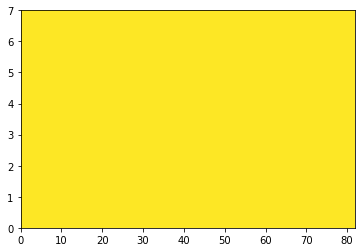

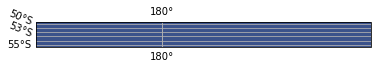

0.0


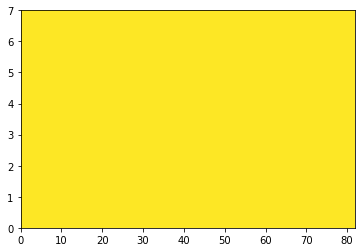

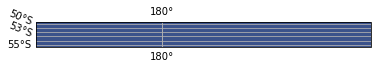

0.0


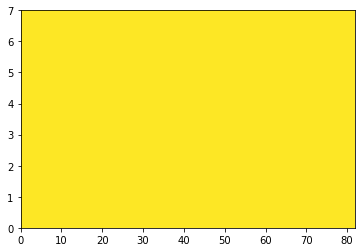

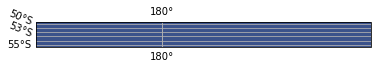

0.0


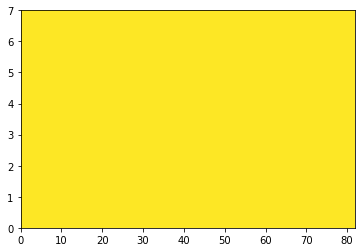

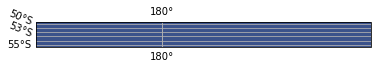

0.0


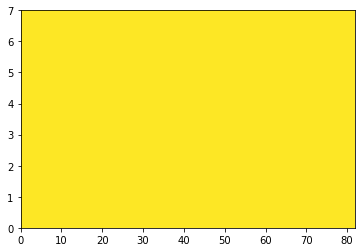

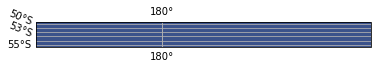

0.0


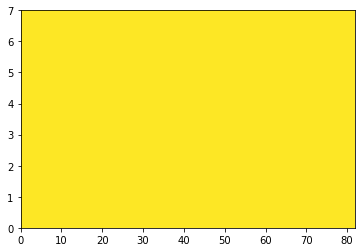

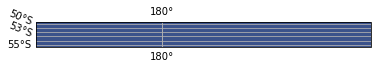

0.0


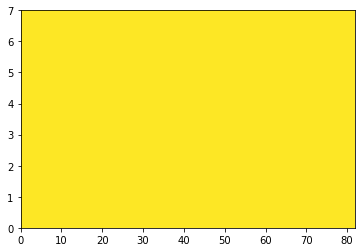

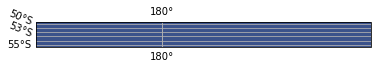

0.0


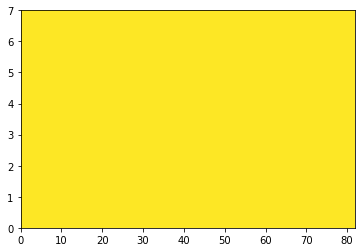

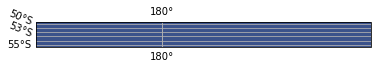

0.0


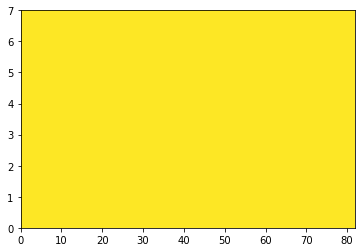

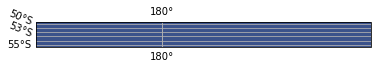

0.0


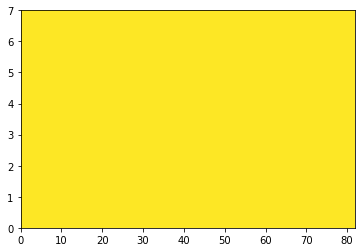

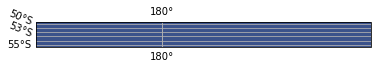

0.0


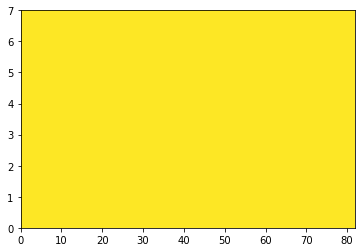

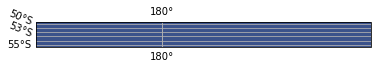

0.0


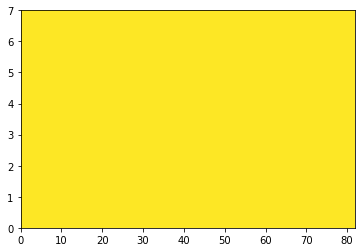

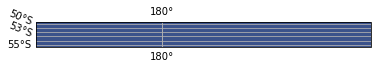

0.0


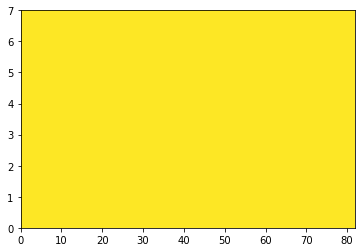

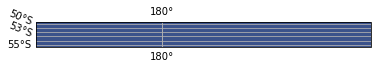

0.0


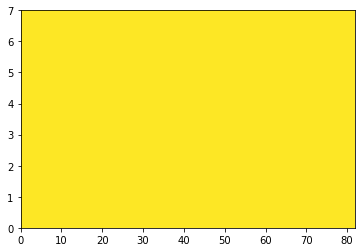

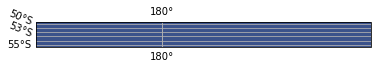

0.0


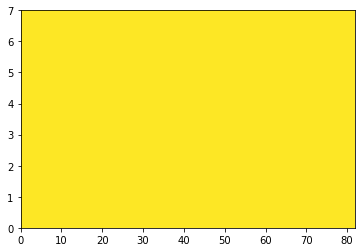

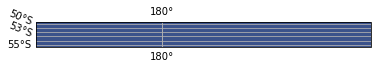

0.0


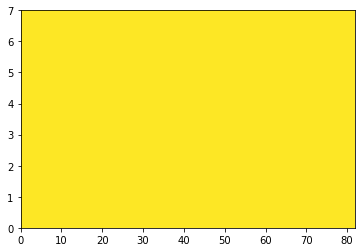

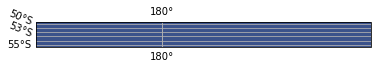

0.0


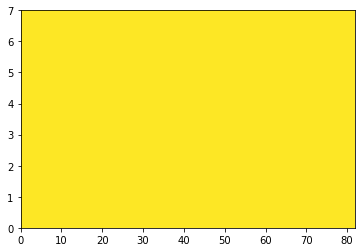

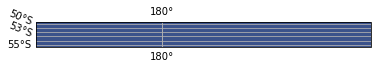

0.0


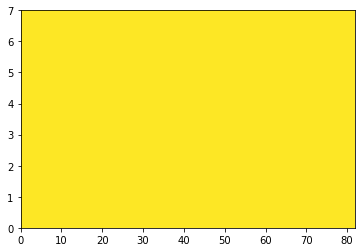

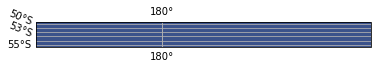

0.0


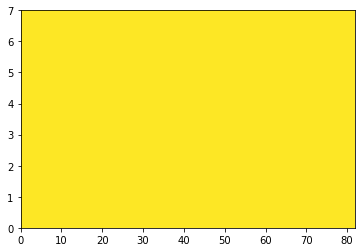

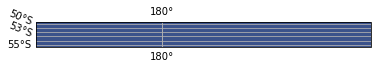

0.0


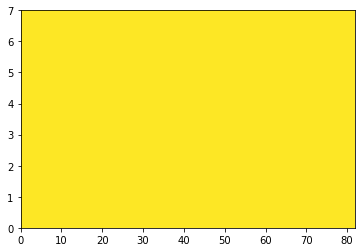

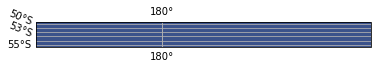

0.0


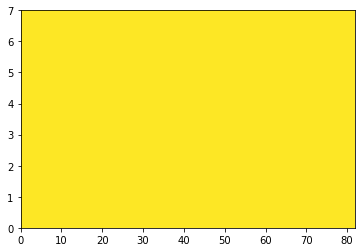

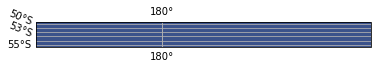

0.0


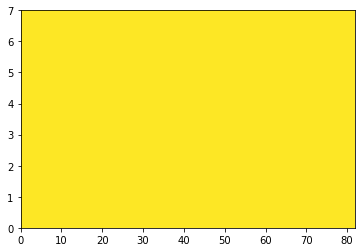

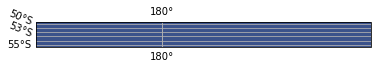

0.0


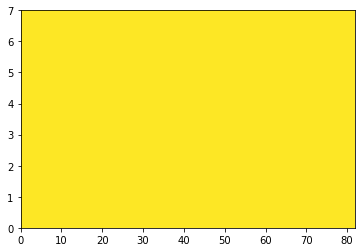

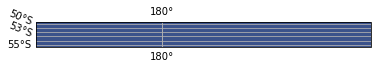

0.0


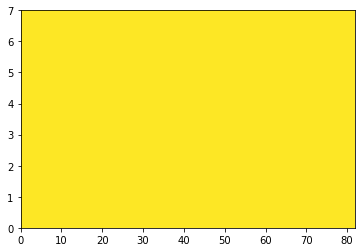

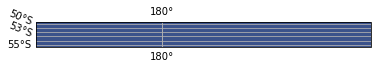

0.0


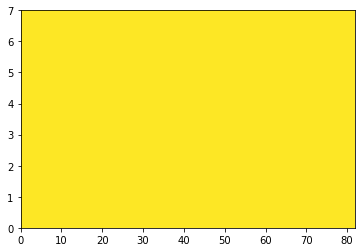

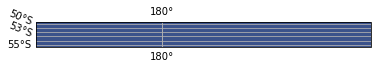

0.0


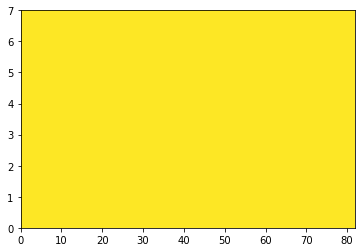

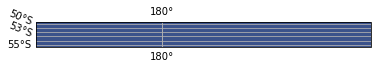

0.0


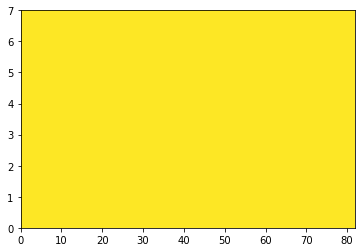

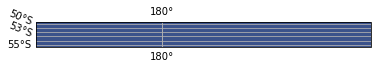

0.0


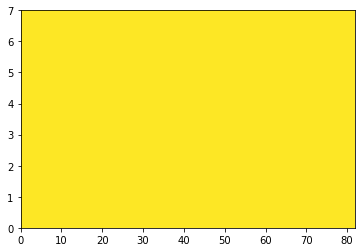

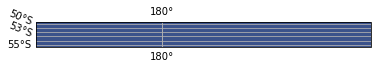

0.0


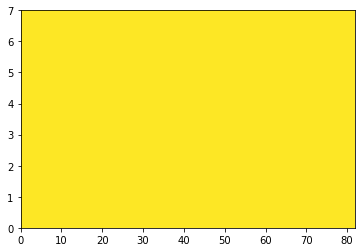

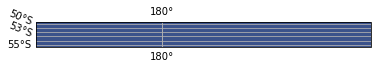

0.0


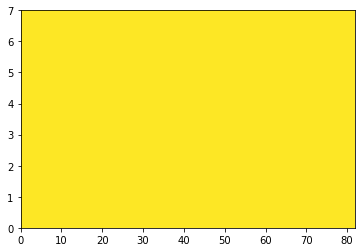

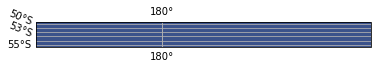

0.0


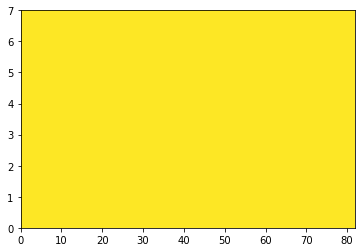

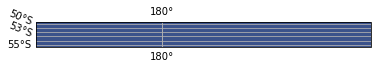

0.0


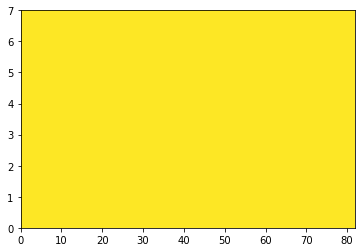

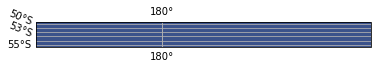

0.0


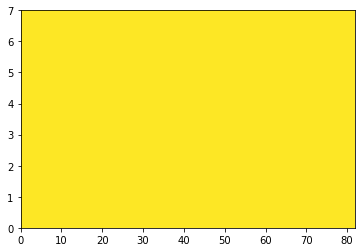

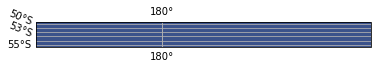

0.0


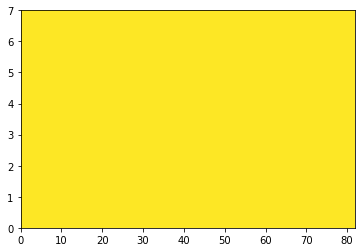

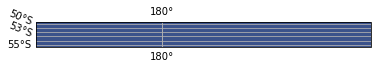

0.0


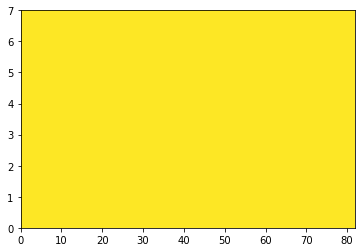

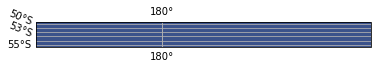

0.0


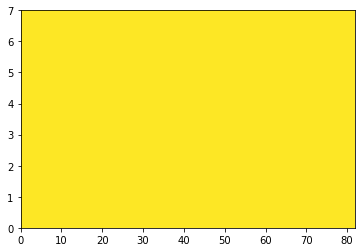

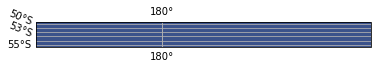

0.0


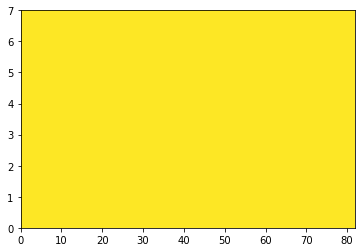

In [36]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import matplotlib.ticker as mticker 
from numpy import *
from matplotlib.pyplot import *
from iris.analysis import *
from iris.coord_categorisation import * 
from iris.analysis.cartography import * 
from scipy.stats import *
from scipy.stats.mstats import *
from iris import *

import warnings
warnings.filterwarnings("ignore")

fname = '/Users/alicebrindley/OneDrive - University of Exeter/siconc_SImon_GFDL-CM4_ssp585_r1i1p1f1_gr_201501-210012.nc'
cube = iris.load(fname)

siconc=cube[2] 
add_month_number(siconc, 'time', name='month_number2')
cube2 = siconc[np.where((siconc.coord('month_number2').points == 2))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(cube2, 'time', name='season_year')
#then average by the season year:
cube2.aggregated_by(['season_year'], iris.analysis.MEAN)

fgname = ('/Users/alicebrindley/Dropbox/YEAR_3/Dissertation/fgco2_files/fgco2_picontrol/outfile')
fgcube = iris.load(fgname)
fgcube1=fgcube[2] 

#extract Jan and Dec to average the sea ice concentration across these mon
add_month_number(fgcube1, 'time', name='month_number1')
fgcube2 = fgcube1[np.where((fgcube1.coord('month_number1').points == 2))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(fgcube2, 'time', name='season_year')
#then average by the season year:
fgcube2.aggregated_by(['season_year'], iris.analysis.MEAN)
#cube2 is therefore the data per season


# Extract the regionan of interst across teh whole cube just once at that start
west = -210 
east = -130 
south = -55
north = -50

temporary_cube = cube2.intersection(longitude = (west, east)) 
cube2 = temporary_cube.intersection(latitude = (south, north))

fg_temporary_cube = fgcube2.intersection(longitude = (west, east)) 
fgcube2 = fg_temporary_cube.intersection(latitude = (south, north))


#Make a 3D copy of the input cube to hold teh output
polynya_location_cube = cube2.copy()
#have a variable holding just the data from this into which we can push teh processed data
polynya_location_cube_data = polynya_location_cube.data
#not just set that all to missing data (nans) so that we know if we have data in it it is real data we want not just leftovers.
polynya_location_cube_data[:] = np.nan

#start of the loop
for i in range (0,2101-2015):
    regional_cube=cube2[i,:,:]
    ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
    my_plot = iplt.contourf(regional_cube)
    plt.gca().gridlines(draw_labels=True)
    plt.show()

    #this is not needed now because it is not used in this part of the script.
    # fg_regional_cube = fgcube2[i,:,:]
    # ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
    # my_plot = iplt.contourf(fg_regional_cube)
    # plt.gca().gridlines(draw_labels=True)
    # #print(fgcube3.coord('time'))
    # #plt.show()

#extract the latitude I want to work with
    #north_edge = regional_cube.collapsed('latitude', iris.analysis.MEAN)
    #average across this latitude
    #nE_mean = north_edge.collapsed('longitude', iris.analysis.MEAN)
    #print(nE_mean.data)
    #latitude = -72,-72.5,-73,-73.5,-74,-74.5,-75
    grid_areas = area_weights(regional_cube)
    average_variable = regional_cube.collapsed(['latitude', 'longitude'],MEAN,weights=grid_areas)
    print(average_variable.data)
    #north_edge = regional_cube.extract(iris.Constraint(latitude=[-72,-72.5,-73,-73.5,-74,-74.5,-75,-75.5,-76]))
    #average across this latitude
    #nE_mean = north_edge.collapsed('longitude', iris.analysis.MEAN)
    #print(nE_mean)
 
    if average_variable.data== 0:
        #define siconc for polynya
        polynya_threshold=regional_cube.data
        polynya = np.where(polynya_threshold.data ==0)
        #print(polynya)
        polynya = polynya_threshold.data
        #plt.pcolormesh(polynya_threshold.data,vmin=0,vmax=100)
        plt.show()

        #define a variable to hold the threshold number you are interested in
        polynya_threshold_value = 0.0
        #Take a copy of the seaice data that we are going to use to make a binary 'mask' showing presence of absense of polynyas as 1s and 0s
        polynya_location = polynya_threshold.data.copy()
        #set that land data in this mask to nan (Not a number) so we don;t get confused (these will show up white in a typical plot)
        polynya_location[np.where(polynya_location >= 1.0e9)] = np.nan
        #make water that has more ice than our polynia condition equal to zero.
        polynya_location[np.where((polynya_location <= 100.0))] = 1.0
        #make water that has less ice than our polynia condition equal to zero to make where the polynya is
        #polynya_location[np.where((polynya_location > 0.0) & (polynya_location <= polynya_threshold_value))] = 1.0
        
        #Assign the data to that particular year in the 3D output array:
        polynya_location_cube_data[i,:,:] = polynya_location
        
        #plot this data
        plt.pcolormesh(polynya_location,vmin=0,vmax=1)
        
        plt.show()
        
#Put th polynia data array nack in to the cube wich holds al o fteh metadata etc.
polynya_location_cube.data = polynya_location_cube_data
        
        #Note in this 1st situation, we have not tested to make sure the northern edge has >30% seaice and it has not, so it is eroniously identify
        
        
        #total_temporary_cube = fg_regional_cube.intersection(longitude = (west, east)) 
        #total_regional_cube = total_temporary_cube.intersection(latitude = (south, north))
        #ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
        #qplt.pcolormesh(polynya_location.data * fg_regional_cube)

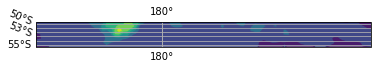

In [37]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) 
my_plot = iplt.contourf(fgcube2[0])
plt.gca().gridlines(draw_labels=True)

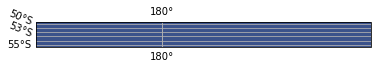

In [38]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
my_plot = iplt.contourf(polynya_location_cube[0])
plt.gca().gridlines(draw_labels=True)

In [39]:
masked_co2_flux = polynya_location_cube * fgcube2[86,:,:]

In [40]:
masked_co2_flux.data[np.logical_not(np.isfinite(masked_co2_flux.data))] = 0

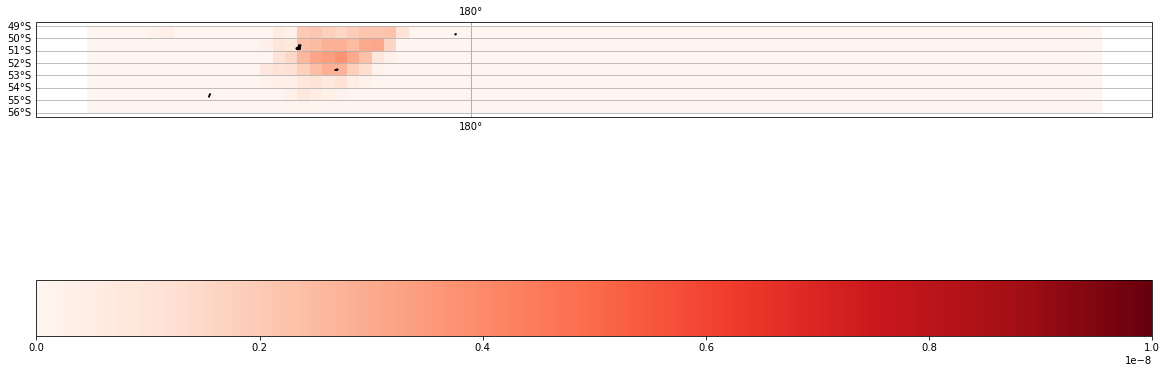

In [41]:
 # adding this so that I can add colour to the land and make sure everything make sense
import cartopy.feature as cfeature # Which time step to plot?

time_slice = 1
plt.figure(figsize=(20,20))
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) # 
my_plot = iplt.pcolormesh(fgcube2[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0e-8)
my_plot = iplt.pcolormesh(polynya_location_cube[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0)
my_plot = iplt.pcolormesh(masked_co2_flux[time_slice],cmap='Reds',vmin=0.0,vmax=1.0e-8) 
plt.gca().gridlines(draw_labels=True)
# Adding shading for land and coastline
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
# adding a colourbar so I can see what the values are
plt.colorbar(orientation='horizontal')

In [42]:
for i in range (0,2101-2015):
    output = np.nansum(polynya_location_cube_data[i,:,:])
    print(output)
#not sure i have weighted the cubes but kinda assume i dont need to do this?

574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0
574.0


In [43]:
def area_avg(cube): 
    try:
        cube.coord('latitude').guess_bounds() 
    except:
        pass 
    try:
        cube.coord('longitude').guess_bounds() 
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

In [44]:
masked_co2_flux_timeseries = area_avg(masked_co2_flux)

Text(0.5, 0, 'Year')

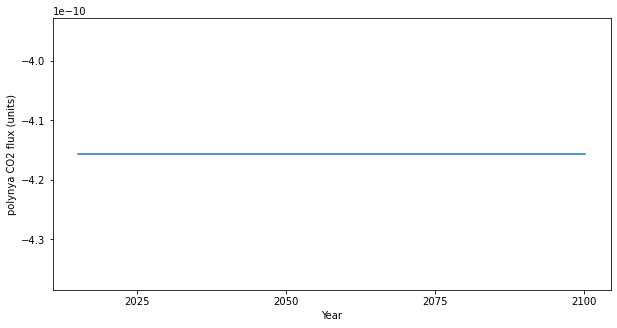

In [45]:
plt.figure(figsize=(10,5)) 
iplt.plot(masked_co2_flux_timeseries) 

plt.ylabel('polynya CO2 flux (units)') 
plt.xlabel('Year')




In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [10,20,30]
y1 = [20,40,10]
# plotting the line 1 points 
plt.plot(x1, y1, label = "line 1")
# line 2 points
x2 = [10,20,30]
y2 = [40,10,30]
# plotting the line 2 points 
plt.plot(x2, y2, label = "line 2")
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Two or more lines on same plot with suitable legends ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [10]:
print(fgcube2,'season year')

surface_downward_mass_flux_of_carbon_dioxide_expressed_as_carbon / (kg m-2 s-1) (time: 165; latitude: 15; longitude: 102)
    Dimension coordinates:
        time                                                                         x              -              -
        latitude                                                                     -              x              -
        longitude                                                                    -              -              x
    Auxiliary coordinates:
        month_number1                                                                x              -              -
        season_year                                                                  x              -              -
    Cell methods:
        mean where sea                                                          area
        mean                                                                    time
    Attributes:
        CDI                        

In [56]:
fgcube

[<iris 'Cube' of Longitude of tracer (T) points / (degrees) (latitude: 180; longitude: 360)>,
<iris 'Cube' of Latitude of tracer (T) points / (degrees) (latitude: 180; longitude: 360)>,
<iris 'Cube' of surface_downward_mass_flux_of_carbon_dioxide_expressed_as_carbon / (kg m-2 s-1) (time: 1980; latitude: 180; longitude: 360)>]

In [49]:
print(fgcube2)


surface_downward_mass_flux_of_carbon_dioxide_expressed_as_carbon / (kg m-2 s-1) (time: 165; latitude: 15; longitude: 102)
    Dimension coordinates:
        time                                                                         x              -              -
        latitude                                                                     -              x              -
        longitude                                                                    -              -              x
    Auxiliary coordinates:
        month_number1                                                                x              -              -
        season_year                                                                  x              -              -
    Cell methods:
        mean where sea                                                          area
        mean                                                                    time
    Attributes:
        CDI                        